Time step 0, Average cooperation: 0.5000


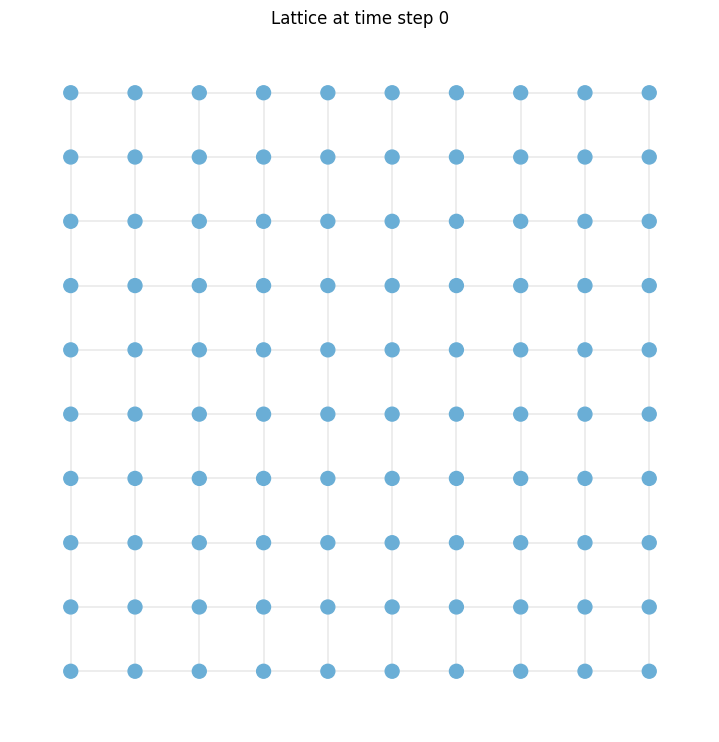

Time step 10000, Average cooperation: 0.4455
Time step 20000, Average cooperation: 0.3772
Time step 30000, Average cooperation: 0.2253
Time step 40000, Average cooperation: 0.0439
Time step 50000, Average cooperation: 0.0134


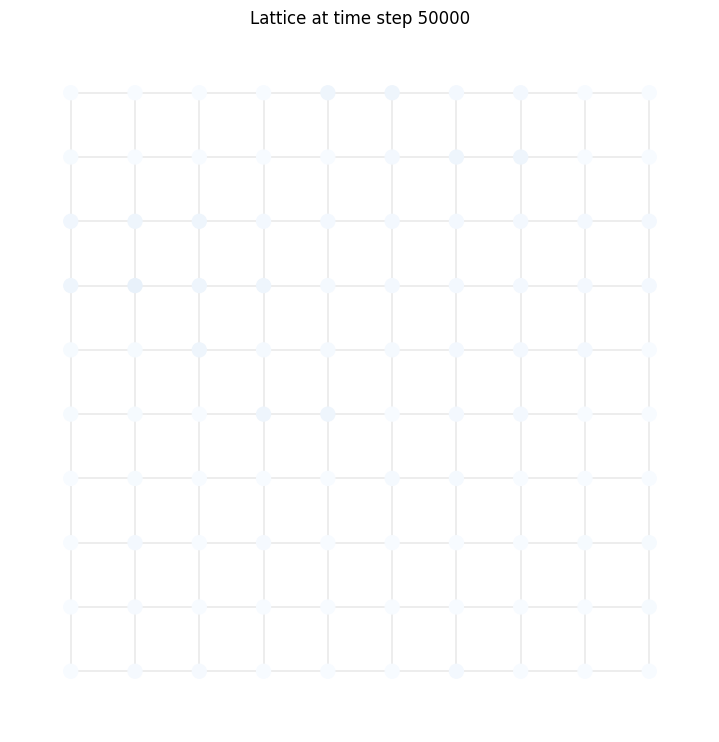

Time step 60000, Average cooperation: 0.0231
Time step 70000, Average cooperation: 0.0074


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import networkx as nx
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Adjust grid size to 30x30
GRID_SIZE = 10
NUM_AGENTS = GRID_SIZE * GRID_SIZE  # Total number of agents
RICH_SITE_PROB = 0.0  # Fraction of rich sites (adjust as needed)
INITIAL_STRATEGY_VALUE = 0.5  # Start with all defectors
c = 10  # Resource contrast (c) between rich and poor sites
b = 1.1  # Temptation to defect
TEMPTATION_LEVEL = b - 1
m = 10  # Parameter for strategy change

# Payoff matrix parameters
RICH_RESOURCE = 1 + c
POOR_RESOURCE = 1

# Create a 2D grid of agents (lattice)
def create_lattice():
    G = nx.grid_2d_graph(GRID_SIZE, GRID_SIZE, periodic=True)  # 2D grid with periodic boundary
    assign_resources(G)
    initialize_strategies(G, INITIAL_STRATEGY_VALUE)
    return G

# Assign resources to rich, poor, and average sites
def assign_resources(G):
    for node in G.nodes():
        rand = random.random()
        if rand < RICH_SITE_PROB:
            G.nodes[node]['resource'] = RICH_RESOURCE
            G.nodes[node]['site_type'] = 'rich'
        else:
            G.nodes[node]['resource'] = POOR_RESOURCE
            G.nodes[node]['site_type'] = 'poor'

# Initialize strategies for agents (probabilities between 0 and 1)
def initialize_strategies(G, initial_value=0.0):
    for node in G.nodes():
        G.nodes[node]['strategy'] = initial_value

# Play the game for one time step and calculate payoffs
def play_game(G):
    payoffs = {}
    for node in G.nodes():
        strategy = G.nodes[node]['strategy']  # Probability to cooperate
        site = G.nodes[node]['site_type']
        payoff = 0
        neighbors = list(G.neighbors(node))

        for neighbor in neighbors:
            neighbor_strategy = G.nodes[neighbor]['strategy']  # Probability to cooperate
            neighbor_site = G.nodes[neighbor]['site_type']

            # Determine actions based on probabilities
            action = 'C' if random.random() < strategy else 'D'
            neighbor_action = 'C' if random.random() < neighbor_strategy else 'D'

            # Calculate payoff based on actions
            payoff += calculate_payoff(action, site, neighbor_action, neighbor_site)

        payoffs[node] = payoff
    return payoffs

def calculate_payoff(action, site, neighbor_action, neighbor_site):
    payoff = 0
    b_local = b
    c_local = c

    if site == 'rich':
        # Implement rich site payoffs if needed
        pass  # Since RICH_SITE_PROB = 0.0, this branch won't be used
    else:  # site == 'poor'
        if action == 'C':
            if neighbor_action == 'C':
                payoff = 1
            else:
                payoff = 0
        else:  # action == 'D'
            if neighbor_action == 'C':
                payoff = b_local
            else:
                payoff = b_local - 1

    return payoff

# Update strategies based on payoffs and stochastic imitation
def update_strategies(G, payoffs):
    mutation_prob = 0.05  # 5% chance of mutation
    node = random.choice(list(G.nodes()))
    if random.random() < mutation_prob:
        # Mutate strategy
        current_strategy = G.nodes[node]['strategy']
        mutation = random.uniform(-0.05, 0.05)
        new_strategy = current_strategy + mutation
        new_strategy = min(max(new_strategy, 0.0), 1.0)  # Ensure within [0, 1]
    else:
        neighbors = list(G.neighbors(node))
        neighbors.append(node)  # Include self in possible models
        total_payoff = 0.0
        payoff_list = []

        # Compute total payoff raised to exponent m
        for neighbor in neighbors:
            payoff = payoffs[neighbor]
            payoff_m = payoff ** m  # Assuming payoffs are non-negative
            payoff_list.append((neighbor, payoff_m))
            total_payoff += payoff_m

        if total_payoff == 0:
            # All payoffs are zero; choose randomly
            selected_neighbor = random.choice(neighbors)
        else:
            # Select a neighbor proportional to payoff^m
            probabilities = [payoff_m / total_payoff for _, payoff_m in payoff_list]
            selected_neighbor = random.choices(
                [neighbor for neighbor, _ in payoff_list],
                weights=probabilities,
                k=1
            )[0]

        # Adjust strategy towards selected neighbor's strategy
        current_strategy = G.nodes[node]['strategy']
        neighbor_strategy = G.nodes[selected_neighbor]['strategy']
        learning_rate = 1.0  # You can adjust the learning rate (1.0 means full adoption)
        new_strategy = current_strategy + learning_rate * (neighbor_strategy - current_strategy)

    # Apply the new strategy to the node
    G.nodes[node]['strategy'] = min(max(new_strategy, 0.0), 1.0)  # Ensure within [0, 1]

def plot_lattice(G, timestep):


    # Collect strategy values (probabilities between 0 and 1)
    node_values = [G.nodes[node]['strategy'] for node in G.nodes()]
    
    # Normalize the strategy values to [0, 1]
    norm = mcolors.Normalize(vmin=0.0, vmax=1.0)
    cmap = cm.Blues  # Use the 'Blues' colormap

    # Map normalized strategy values to colors
    node_colors = [cmap(norm(value)) for value in node_values]

    # Draw the grid with proper node colors
    pos = dict((n, n) for n in G.nodes())  # Use grid positions
    plt.figure(figsize=(7, 7))
    nx.draw(G, pos, node_color=node_colors, with_labels=False, node_size=100, edge_color='black', width=0.05)
    plt.title(f"Lattice at time step {timestep}")
    plt.show()

# Simulation loop
def simulate():
    G = create_lattice()
    cooperation_levels = []
    num_steps = 500000

    for t in range(num_steps):
        payoffs = play_game(G)
        update_strategies(G, payoffs)
        
        if t % 10000 == 0:
            # Calculate average cooperation probability
            total_strategy = sum(G.nodes[node]['strategy'] for node in G.nodes())
            avg_cooperation = total_strategy / NUM_AGENTS
            cooperation_levels.append(avg_cooperation)
            print(f"Time step {t}, Average cooperation: {avg_cooperation:.4f}")
            
            if t % 50000 == 0:
                plot_lattice(G, t)
    
    return cooperation_levels, G

# Run the simulation and plot the final state
cooperation_levels, G = simulate()

# Plot the cooperation level over time
plt.plot(np.arange(len(cooperation_levels)) * 100000, cooperation_levels)
plt.xlabel("Time step")
plt.ylabel("Average Cooperation Level")
plt.title("Cooperation Level Over Time")
plt.show()
